# Task

Keep using the One-piece [competition case](https://www.kaggle.com/t/f5f7783abf31495f9593b3d93a18f9eb).

This time, it is based on the multiple linear regression framework as in the Assignment 2 (yes, as a TV series).
$$y=x'\beta + \epsilon.$$


1. Have you transformed any variables?
Polynomial transformation? Interactions?
1. Week 6 will talk about LOWESS, a simple nonparametric method.
1. Model averaging (or model assembly in ML language, stacking in particular). If you have a few competitive models, sometimes, the average of their predictions is better than any single model's prediction.
1. Get the test sample for prediction and submit your results on Kaggle to get your Kaggle score screenshot. Show the screenshot in the PDF file.

**Note:**
- All instructions in Assignment 1 apply.
- Use $\leq 300$ words.

## Install Packages

In [128]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import  Lasso, LinearRegression,LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from itertools import combinations
from sklearn.metrics import mean_squared_error

## 1. Read Data

In [129]:
train_url = "https://github.com/joshcpld/ada/raw/main/Assignment%202/data/train_data.csv"
train_df = pd.read_csv(train_url)
test_url = "https://github.com/joshcpld/ada/raw/main/Assignment%202/data/test_data.csv"
test_df = pd.read_csv(test_url)

train_df.head()

,ID,Y,X1,X2,X3,X4,X5,X6,X7,X8,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,0,-1.399091,1.174139,1.413109,0.164693,-1.067338,0.015324,-1.280970,0.489681,-0.371982,...,-0.115044,-2.580043,-0.812428,0.772820,-0.460444,0.190422,-0.362052,-1.119038,0.916313,-1.517434
1,1,3.097990,0.208922,0.931231,0.838779,0.893483,-0.510555,0.900289,-0.042490,0.839400,...,1.155635,0.673035,-0.438152,-0.001316,-0.761800,1.335092,0.901978,-1.549504,-0.456224,0.223405
2,2,-1.707346,-0.744982,0.962118,0.615392,-0.427943,-0.014912,1.138781,1.159491,0.055467,...,0.299277,1.387495,-0.007519,-0.464825,0.830986,0.373124,0.319232,-0.577295,-1.363846,-0.347154
3,3,0.610625,-0.170428,-1.361771,0.206042,0.623124,0.907441,-0.873814,1.287383,0.901191,...,1.209247,0.095866,-0.287905,-1.110714,-1.660352,0.207231,-0.419119,-0.517563,-1.050697,-0.096327
4,4,-0.689196,-0.858792,0.321308,-0.415649,1.014056,-0.522858,0.926634,-0.390663,0.790054,...,-1.191989,-1.127448,0.246358,0.407769,1.132454,-0.016621,0.964745,0.091532,0.649593,-0.818020


## 2. LASSO Regularisation with K-fold CV

In this section, we begin with LASSO regularisation to reduce our parameter scope using cross-validation.

First, we separate the X predictors from our outcome variable Y.

In [130]:
# Separate the X predictors and Y outcome variable
X0_train = train_df.drop(columns=['Y', 'ID'])
y0_train = train_df['Y'].values
cols = X0_train.columns.tolist()

Second, we then create a matrix of higher order polynomial and interaction terms.

In [131]:
# Define function
def matrix(df, cols):
    # Original terms: X1, X2, X3, ..., X50
    base = df[cols].copy()

    # Squared terms: X1^2, X2^2, X3^2, ..., X50^2
    squares = pd.DataFrame({f"{c}^2": df[c]**2 for c in cols}, index=df.index)

    # Interaction terms: X1*X2, X1*X3, ..., X49*X50
    inter_dict = {}
    for i, c1 in enumerate(cols):
        for j in range(i+1, len(cols)):
            c2 = cols[j]
            inter_dict[f"{c1}*{c2}"] = df[c1] * df[c2]
    inter = pd.DataFrame(inter_dict, index=df.index)

    # Combine all together
    X_vars = pd.concat([base, squares, inter], axis=1)
    return X_vars

# Create the polynomial and interaction terms training set
X_vars_train = matrix(train_df, cols)
X_vars_test = matrix(test_df.drop(columns=['ID']), cols)

print("Shape of original training set:", X0_train.shape)
print("Shape of new training set:", X_vars_train.shape)

Shape of original training set: (2400, 50)
Shape of new training set: (2400, 1325)


Third, we scale the predictors to ensure comparability.

In [132]:
scaler = StandardScaler()
X1_train = scaler.fit_transform(X_vars_train.values)

Fourth, we select the 'optimal' alpha for LASSO regularisation (which we combine with cross-validation).

In [133]:
lasso_cv_model = LassoCV(alphas=np.logspace(-5, 2, num=100), cv=10, max_iter=10000)

# Fit the LassoCV model to the scaled training data
lasso_cv_model.fit(X1_train, y0_train)

# The optimal alpha selected by cross-validation
optimal_alpha_lasso = lasso_cv_model.alpha_
print("Optimal Alpha:", optimal_alpha_lasso)

Optimal Alpha: 0.06579332246575675


As we are interested in a range of models, and want to see which set of models perform the best, let us select a range of alphas one standard error from our optimal point.

In [141]:
# Get the mean CV error per alpha
mean_mse = lasso_cv_model.mse_path_.mean(axis=1)

# Calculate the standard error of the mean CV error
std_mse = lasso_cv_model.mse_path_.std(axis=1) / np.sqrt(lasso_cv_model.mse_path_.shape[1])

# Index of best alpha
optimal_alpha_lasso_index = np.where(lasso_cv_model.alphas_ == optimal_alpha_lasso)[0][0]

# Create a threshold using one standard error from the mean CV error of the optimal alpha
alpha_threshold = mean_mse[optimal_alpha_lasso_index] + std_mse[optimal_alpha_lasso_index]

# Apply this threshold to select a set of alphas
threshold_inequality = mean_mse <= alpha_threshold
selected_alphas = lasso_cv_model.alphas_[threshold_inequality]

# Use LASSO on these set of alphas to select a set of features for our multiple linear regression model
LASSO_features = {}
for a in selected_alphas:
    model = Lasso(alpha=a).fit(X1_train, y0_train)
    LASSO_features[a] = model
    n_predictors = np.sum(model.coef_ != 0)
    print(f"alpha={a:.5f} | predictors={n_predictors}")

alpha=0.09112 | predictors=88
alpha=0.07743 | predictors=129
alpha=0.06579 | predictors=186
alpha=0.05591 | predictors=234
alpha=0.04751 | predictors=300


## 3. Model Averaging and Evaluation

In this section, we attempt to select which combination of multiple linear regression models performs best on the training data. The average of the model combinations that perform the best will be selected for our model prediction.

In [135]:
# Create 5 fold CV to evaluate the performance of each model combination
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
model_names = list(selected_predictors.keys())
cv_mse = {}

# Loop through all combinations of models
for i in range(1, len(model_names) + 1):
    for x in combinations(model_names, i): # Generate all combinations of model names of size i
        fold_mse = [] # Store the MSE for each fold
        for train_idx, val_idx in k_fold.split(X_vars_train):
            y_train, y_val = y0_train[train_idx], y0_train[val_idx] # Split the training data into training and validation subsets
            preds = [] # Store each of the predictions into this vector
            for name in x: # Loop through each model in the combination
                X_train = X_vars_train.iloc[train_idx][selected_predictors[name]] # Obtain the predictors for the training model
                X_val   = X_vars_train.iloc[val_idx][selected_predictors[name]] # Obtain the predictors for the validation model
                m = LinearRegression().fit(X_train, y_train) # Fit the multiple linear regression model on the training subset
                preds.append(m.predict(X_val)) # Predict the validation subset and store the predictions
            avg_pred = np.column_stack(preds).mean(axis=1) # Average the prediction from each model combination
            fold_mse.append(mean_squared_error(y_val, avg_pred)) # Compute the MSE for this fold and then store it
        cv_mse[x] = np.mean(fold_mse) # Once each fold is complete, average the MSE folds to get the CV error for this model combination
sorted_cv_mse = sorted(cv_mse.items(), key=lambda x: x[1]) # Sort the model combinations by the smallest CV error
cv_mse_df = pd.DataFrame(sorted_cv_mse, columns=["Models", "CV_MSE"]) # Store the results into a dataframe
cv_mse_df

,Models,CV_MSE
0,"(Model 1, Model 4, Model 5)",3.745852
1,"(Model 1, Model 2, Model 4, Model 5)",3.750419
2,"(Model 1, Model 3, Model 5)",3.754361
3,"(Model 1, Model 3, Model 4, Model 5)",3.754469
4,"(Model 1, Model 5)",3.758442
5,"(Model 1, Model 2, Model 3, Model 4, Model 5)",3.758829
6,"(Model 2, Model 4, Model 5)",3.770804
7,"(Model 1, Model 2, Model 3, Model 5)",3.770859
8,"(Model 2, Model 5)",3.774660
9,"(Model 1, Model 2, Model 5)",3.774787


Given that the combination of Model 1, 4, and 5 performs the best. We will use this combination for our final prediction set.

## 4. Model Prediction

In this section, we will average the predictions from Model 1, 4, and 5 for our test set.

In [136]:
# Select the models of interest
models_to_use = ["Model 1", "Model 4", "Model 5"]

# Create a vector to store our predictions
preds_test = []

# Loop through each model, fit each model, and then make predictions using the set set
for name in models_to_use:
    cols = selected_predictors[name]
    m = LinearRegression().fit(X_vars_train[cols], y0_train)
    preds_test.append(m.predict(X_vars_test[cols]))  

# Average the predictions from each model
y_pred_test = np.column_stack(preds_test).mean(axis=1)

# Create the csv file for submission
submission_ass3_url = "https://github.com/joshcpld/ada/blob/main/Assignment%203/data/submission.csv?raw=true"
submission_ass3 = pd.read_csv(submission_ass3_url)
submission_ass3 = pd.DataFrame({'ID': test_df['ID'], 'Y': y_pred_test})
submission_ass3.to_csv('submission_ass3_group9.csv', index=False)

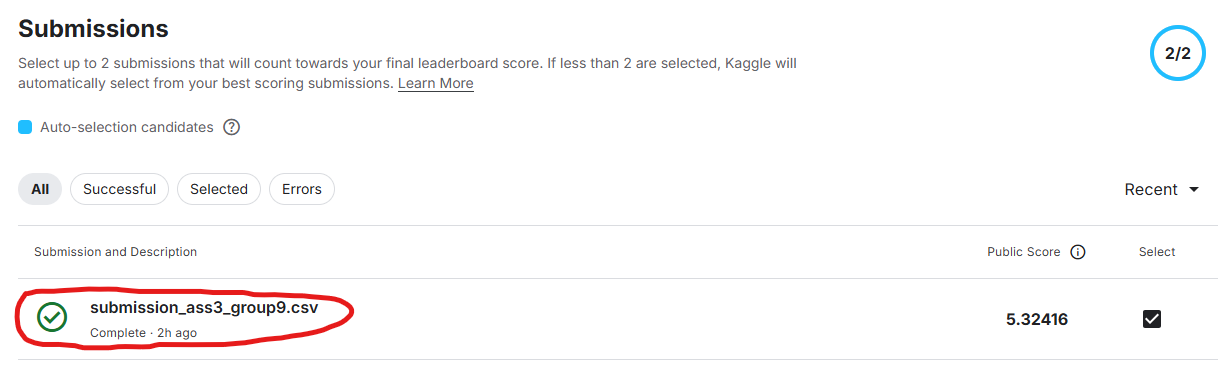
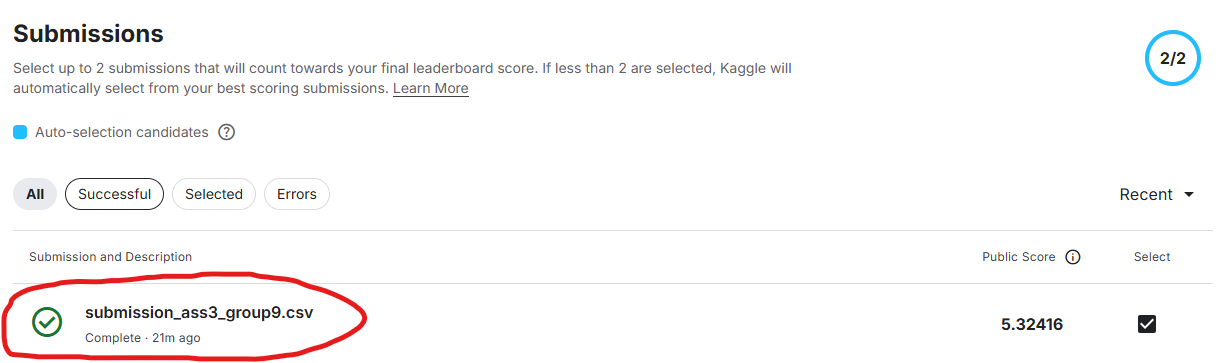